#  Bloque 1 

In [2]:
# ==========================================
# BLOQUE 1: SETUP ENTORNO (SILENCIOSO & ROBUSTO)
# ==========================================
# @title 1. Configuración Inicial y Corrección de Librerías
import os
import sys
import subprocess
import warnings
import importlib

# Suprimir advertencias de Python
warnings.filterwarnings("ignore")

def setup_environment():
    print("🏗️ Configurando entorno de trabajo...")
    
    def robust_install(package_list):
        # Instalación silenciosa: capturamos stdout y stderr para no ensuciar la consola
        # con conflictos de dependencias irrelevantes (bigframes, tensorflow, etc.)
        try:
            print(f"   ⚙️ Instalando/Verificando: {' '.join(package_list)} ...")
            subprocess.run(
                [sys.executable, "-m", "pip", "install", "-q"] + package_list,
                check=True,  # Verificamos si pip falla catastróficamente
                capture_output=True, # Ocultamos el texto rojo de conflictos
                text=True
            )
            return True
        except subprocess.CalledProcessError as e:
            # Si falla, revisamos si es un error crítico o solo advertencias
            # Para este caso, asumimos que si SAM 2 carga después, todo está bien.
            return False

    # 1. GESTIÓN DE NUMPY (CRÍTICO: MANTENER < 2.0)
    try:
        import numpy
        # Si detectamos Numpy 2.x, forzamos downgrade inmediato
        if numpy.__version__.startswith("2"):
            print("   ⚠️ Numpy 2.x detectado (Incompatible). Realizando downgrade a 1.x...")
            robust_install(["numpy<2"])
            print("   🔄 Numpy corregido. Si hay errores posteriores, REINICIA EL KERNEL.")
    except ImportError:
        robust_install(["numpy<2"])

    # 2. INSTALACIÓN DE SAM 2
    try:
        import sam2
        print("   ✅ SAM 2 listo.")
    except ImportError:
        robust_install(["git+https://github.com/facebookresearch/segment-anything-2.git"])

    # 3. INSTALACIÓN GEOESPACIAL
    try:
        import geopandas
        import rasterio
        print("   ✅ Geoespacial listo.")
    except ImportError:
        robust_install(["shapely", "geopandas", "rasterio", "opencv-python-headless"])
    
    print("✅ Entorno configurado correctamente.")

setup_environment()

# --- IMPORTACIONES ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import requests
from shapely.geometry import Polygon
import geopandas as gpd
import torch

# --- CONFIGURACIÓN HARDWARE ---
if torch.cuda.is_available():
    DEVICE = "cuda"
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 GPU Activa: {gpu_name}")
    
    # Optimización de precisión según arquitectura
    if "T4" in gpu_name or "A100" in gpu_name:
        torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
        # Activar TensorCores para matrices
        if torch.cuda.get_device_properties(0).major >= 8:
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
else:
    DEVICE = "cpu"
    print("⚠️ ADVERTENCIA: Estás usando CPU. Activa la GPU (T4/P100) para velocidad real.")

# --- DIRECTORIOS ---
try:
    WORK_DIR = "/kaggle/working" if os.path.exists("/kaggle/working") else os.getcwd()
except:
    WORK_DIR = "."
    
OUTPUT_DIR = os.path.join(WORK_DIR, "output_tiles")
os.makedirs(OUTPUT_DIR, exist_ok=True)

🏗️ Configurando entorno de trabajo...
   ✅ SAM 2 listo.
   ✅ Geoespacial listo.
✅ Entorno configurado correctamente.
🚀 GPU Activa: Tesla T4


#  Bloque 2

In [3]:

# ==========================================
# BLOQUE 2: CARGA DE IMAGEN
# ==========================================
# @title 2. Carga de Mapa Geológico
original_image_global = None
processed_image_global = None

def image_loader_ui():
    style = {'description_width': 'initial'}
    
    # UI Elements
    lbl_title = widgets.HTML("<h3>📍 Carga de Imagen</h3>")
    source_w = widgets.Dropdown(options=['GitHub URL', 'Subir Archivo'], value='GitHub URL', description='Fuente:', style=style)
    url_w = widgets.Text(value="https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/gironim.png", placeholder='URL...', layout=widgets.Layout(width='60%'))
    upload_w = widgets.FileUpload(accept='image/*', multiple=False)
    btn_load = widgets.Button(description="Cargar", button_style='primary')
    out = widgets.Output()

    def on_load(b):
        global original_image_global
        with out:
            clear_output()
            try:
                if source_w.value == 'GitHub URL':
                    print(f"Descargando: {url_w.value} ...")
                    resp = requests.get(url_w.value, stream=True).raw
                    original_image_global = Image.open(resp).convert("RGB")
                else:
                    if not upload_w.value: return print("❌ Selecciona un archivo.")
                    f_info = next(iter(upload_w.value.values())) # Kaggle file upload struct
                    original_image_global = Image.open(io.BytesIO(f_info['content'])).convert("RGB")
                
                print(f"✅ Imagen cargada: {original_image_global.size}")
                # Mostrar thumbnail
                thumb = original_image_global.copy()
                thumb.thumbnail((400, 400))
                display(thumb)
                
            except Exception as e:
                print(f"❌ Error: {e}")

    btn_load.on_click(on_load)
    display(widgets.VBox([lbl_title, widgets.HBox([source_w, url_w, upload_w, btn_load]), out]))

image_loader_ui()


# Bloque 3

In [4]:
# ==========================================
# BLOQUE 3: PREPROCESAMIENTO
# ==========================================
# @title 3. Ajuste Visual (Preprocesamiento)
def preprocessing_ui():
    style = {'description_width': 'initial'}
    lbl_title = widgets.HTML("<h3>🎨 Ajuste de Imagen (Brillo/Contraste)</h3>")
    
    b_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Brillo')
    c_slider = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description='Contraste')
    s_slider = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Nitidez')
    btn_apply = widgets.Button(description="Confirmar y Guardar", button_style='success')
    out_prev = widgets.Output()

    def update_view(change=None):
        if original_image_global is None: return
        with out_prev:
            clear_output(wait=True)
            img = original_image_global.copy()
            img = ImageEnhance.Brightness(img).enhance(b_slider.value)
            img = ImageEnhance.Contrast(img).enhance(c_slider.value)
            img = ImageEnhance.Sharpness(img).enhance(s_slider.value)
            
            # Preview rápido
            w, h = img.size
            ratio = 500 / w
            plt.figure(figsize=(8, 4))
            plt.imshow(img.resize((500, int(h*ratio))))
            plt.axis('off')
            plt.title("Preview")
            plt.show()

    def apply_filters(b):
        global processed_image_global
        if original_image_global is None: return
        img = original_image_global.copy()
        img = ImageEnhance.Brightness(img).enhance(b_slider.value)
        img = ImageEnhance.Contrast(img).enhance(c_slider.value)
        processed_image_global = ImageEnhance.Sharpness(img).enhance(s_slider.value)
        print("✅ Imagen preprocesada lista para segmentar.")

    b_slider.observe(update_view, names='value')
    c_slider.observe(update_view, names='value')
    s_slider.observe(update_view, names='value')
    btn_apply.on_click(apply_filters)

    display(widgets.VBox([lbl_title, widgets.HBox([b_slider, c_slider, s_slider]), out_prev, btn_apply]))

preprocessing_ui()

# Bloque 4

In [5]:
# ==========================================
# BLOQUE 4: CARGA MODELO SAM 2
# ==========================================
# @title 4. Inicialización del Modelo
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

if not os.path.exists("sam2_hiera_large.pt"):
    print("⬇️ Bajando pesos SAM 2 Large...")
    os.system("wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt")

print("⚙️ Cargando Modelo a GPU...")
torch.set_grad_enabled(False)
sam2_model = build_sam2("sam2_hiera_l.yaml", "sam2_hiera_large.pt", device=DEVICE, apply_postprocessing=False)
print("✅ Modelo cargado en memoria (Weights loaded).")

⬇️ Bajando pesos SAM 2 Large...
⚙️ Cargando Modelo a GPU...
✅ Modelo cargado en memoria (Weights loaded).


# Bloque 5

In [40]:
# ==========================================
# BLOQUE 5: CONSOLA DINÁMICA (LÓGICA UNIFICADA DE POLÍGONOS)
# ==========================================
# @title 5. Explorador Dinámico (Contador Real de Polígonos)

class DynamicTileExplorer:
    def __init__(self, image, model):
        if image is None:
            print("❌ ERROR: Carga la imagen primero (Bloques 2 y 3).")
            return
            
        self.image = np.array(image)
        self.model = model
        self.H, self.W = self.image.shape[:2]
        self.tile_size = 1024
        self.tiles = self._generate_tiles()
        self.current_idx = 0
        
        # --- CACHÉ DE GEOMETRÍA ---
        # Guardaremos directamente los POLÍGONOS finales, no las máscaras
        self.cached_polygons = [] 
        self.current_masks = []
        self.is_processing = False
        
        # --- UI WIDGETS ---
        self.out_display = widgets.Output()
        self.out_status = widgets.Output()
        
        # Navegación
        self.btn_prev = widgets.Button(description="< Ant.", icon='arrow-left', layout=widgets.Layout(width='100px'))
        self.btn_next = widgets.Button(description="Sig. >", icon='arrow-right', layout=widgets.Layout(width='100px'))
        self.lbl_idx = widgets.Label(value=f"Tile: 1 / {len(self.tiles)}")
        
        # Parámetros SAM 2
        style = {'description_width': 'initial'}
        self.sl_points = widgets.IntSlider(value=64, min=32, max=128, step=16, description='Puntos (Densidad)', continuous_update=True, style=style)
        self.sl_iou = widgets.FloatSlider(value=0.70, min=0.1, max=0.99, step=0.05, description='Confianza (IOU)', continuous_update=True, style=style)
        self.sl_stability = widgets.FloatSlider(value=0.85, min=0.5, max=0.99, step=0.05, description='Estabilidad', continuous_update=True, style=style)
        self.sl_min_area = widgets.IntSlider(value=1000, min=10, max=10000, step=10, description='Área Mínima', continuous_update=True, style=style)
        
        # Filtros
        self.chk_bw_filter = widgets.Checkbox(value=True, description='Ignorar Fondo (B/N)')
        self.chk_solidify = widgets.Checkbox(value=True, description='Rellenar Agujeros (Solidificar)')
        self.chk_merge_overlap = widgets.Checkbox(value=True, description='Fusionar Overlap')
        self.sl_overlap_thresh = widgets.FloatSlider(value=0.80, min=0.1, max=1.0, step=0.05, description='Umbral Fusion %', continuous_update=True, style=style)
        self.chk_fill_gaps = widgets.Checkbox(value=True, description='Rellenar Huecos (Gap Fill)')
        self.chk_contours = widgets.Checkbox(value=True, description='Delinear Contornos')
        
        self.btn_save = widgets.Button(description="💾 Guardar (Exacto)", button_style='success', icon='save')
        
        # --- EVENTOS ---
        self.btn_prev.on_click(self.prev_tile)
        self.btn_next.on_click(self.next_tile)
        self.btn_save.on_click(self.save_tile)
        
        # Observers
        self.sl_points.observe(self.on_param_change, names='value')
        self.sl_iou.observe(self.on_param_change, names='value')
        self.sl_stability.observe(self.on_param_change, names='value')
        self.sl_min_area.observe(self.on_param_change, names='value')
        
        self.chk_fill_gaps.observe(self.refresh_visuals, names='value')
        self.chk_bw_filter.observe(self.refresh_visuals, names='value')
        self.chk_contours.observe(self.refresh_visuals, names='value')
        self.chk_merge_overlap.observe(self.refresh_visuals, names='value')
        self.sl_overlap_thresh.observe(self.refresh_visuals, names='value')
        self.chk_solidify.observe(self.refresh_visuals, names='value')

        self.render_ui()
        self.run_inference()

    def _generate_tiles(self):
        coords = []
        stride = int(self.tile_size * 0.9)
        if self.H < self.tile_size or self.W < self.tile_size: return [(0, 0, self.W, self.H)]
        for y in range(0, self.H, stride):
            for x in range(0, self.W, stride):
                x_end = min(x + self.tile_size, self.W)
                y_end = min(y + self.tile_size, self.H)
                coords.append((max(0, x_end - self.tile_size), max(0, y_end - self.tile_size), x_end, y_end))
        return coords

    def get_current_tile_img(self):
        x1, y1, x2, y2 = self.tiles[self.current_idx]
        return self.image[y1:y2, x1:x2]

    def prev_tile(self, b):
        if self.current_idx > 0:
            self.current_idx -= 1
            self.update_nav(); self.run_inference()

    def next_tile(self, b):
        if self.current_idx < len(self.tiles) - 1:
            self.current_idx += 1
            self.update_nav(); self.run_inference()

    def update_nav(self):
        self.lbl_idx.value = f"Tile: {self.current_idx + 1} / {len(self.tiles)}"

    def on_param_change(self, change):
        if not self.is_processing: self.run_inference()

    def solidify_masks(self, masks):
        if not self.chk_solidify.value: return masks
        solid_masks = []
        for m in masks:
            seg = np.ascontiguousarray(m['segmentation'].astype(np.uint8))
            cnts, _ = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            new_mask = np.zeros(seg.shape, dtype=np.uint8)
            cv2.drawContours(new_mask, cnts, -1, 1, thickness=cv2.FILLED)
            m_copy = m.copy()
            m_copy['segmentation'] = new_mask.astype(bool)
            m_copy['area'] = np.sum(new_mask)
            solid_masks.append(m_copy)
        return solid_masks

    def calculate_gaps(self, tile_shape, filtered_masks):
        if not self.chk_fill_gaps.value: return []
        combined = np.zeros(tile_shape[:2], dtype=np.uint8)
        for m in filtered_masks:
            combined = np.bitwise_or(combined, m['segmentation'].astype(np.uint8))
        gaps = 1 - combined
        cnts, _ = cv2.findContours(gaps, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        res = []
        for c in cnts:
            if cv2.contourArea(c) > self.sl_min_area.value:
                m = np.zeros(tile_shape[:2], dtype=np.uint8)
                cv2.drawContours(m, [c], -1, 1, cv2.FILLED)
                res.append({'segmentation': m.astype(bool), 'area': cv2.contourArea(c), 'is_gap': True})
        return res

    def clean_overlaps(self, masks):
        if not self.chk_merge_overlap.value or len(masks) < 2: return masks
        polys = []
        for m in masks:
            cnts, _ = cv2.findContours(m['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if cnts:
                cnt = max(cnts, key=cv2.contourArea)
                if len(cnt) > 2:
                    p = Polygon(cnt.squeeze().reshape(-1, 2))
                    if not p.is_valid: p = p.buffer(0)
                    polys.append({'poly': p, 'data': m, 'keep': True})
        
        polys.sort(key=lambda x: x['data']['area'], reverse=True)
        threshold = self.sl_overlap_thresh.value 
        for i in range(len(polys)):
            if not polys[i]['keep'] or polys[i]['poly'] is None: continue
            p1 = polys[i]['poly']
            for j in range(i + 1, len(polys)):
                if not polys[j]['keep'] or polys[j]['poly'] is None: continue
                p2 = polys[j]['poly']
                try:
                    if p1.intersects(p2):
                        if (p1.intersection(p2).area / p2.area) > threshold:
                            polys[j]['keep'] = False
                except: pass 
        return [p['data'] for p in polys if p['keep']]

    def masks_to_polygons(self, masks, tile_offset=(0,0)):
        """Convierte máscaras en polígonos REALES (maneja islas)."""
        final_polys = []
        x_off, y_off = tile_offset
        
        for item in masks:
            src = 'gap_fill' if item.get('is_gap', False) else 'sam'
            
            # Extraer TODOS los contornos (islas) de esta máscara
            cnts, _ = cv2.findContours(item['segmentation'].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for c in cnts:
                if len(c) > 2:
                    # Convertir a coordenadas globales del tile
                    pts = c.squeeze() + [x_off, y_off]
                    try:
                        poly = Polygon(pts.reshape(-1, 2))
                        
                        # Reparar y Filtrar
                        if not poly.is_valid: 
                            poly = poly.buffer(0)
                        
                        # --- FIX CRÍTICO: MANEJO DE MULTIPOLYGON ---
                        # buffer(0) puede romper un polígono en varios (MultiPolygon)
                        # Debemos aplanarlos para evitar el AttributeError 'exterior'
                        if poly.geom_type == 'MultiPolygon':
                            polys_iter = list(poly.geoms)
                        else:
                            polys_iter = [poly]

                        for p in polys_iter:
                            # Filtro de Área (Asegura que coincida con lo que guardamos)
                            if p.is_valid and not p.is_empty and p.area > 50:
                                final_polys.append({'geometry': p, 'source': src})
                    except Exception:
                        continue
                        
        return final_polys

    def run_inference(self):
        self.is_processing = True
        with self.out_status: print("⚡ Calculando...")
        try:
            mask_generator = SAM2AutomaticMaskGenerator(
                model=self.model,
                points_per_side=self.sl_points.value,
                points_per_batch=64,
                pred_iou_thresh=self.sl_iou.value,
                stability_score_thresh=self.sl_stability.value,
                stability_score_offset=0.7,
                crop_n_layers=0,
                min_mask_region_area=self.sl_min_area.value
            )
            tile = self.get_current_tile_img()
            self.current_masks = mask_generator.generate(tile)
            del mask_generator; torch.cuda.empty_cache()
            self.plot_results()
        except Exception as e:
            with self.out_status: clear_output(); print(f"❌ Error: {e}")
        finally:
            self.is_processing = False

    def refresh_visuals(self, change):
        self.plot_results()

    def plot_results(self):
        with self.out_display:
            clear_output(wait=True)
            tile = self.get_current_tile_img()
            x1, y1 = self.tiles[self.current_idx][:2]
            
            # --- 1. PROCESAMIENTO DE MÁSCARAS ---
            valid_masks = []
            if self.current_masks:
                working_masks = [m.copy() for m in self.current_masks]
                for m in working_masks:
                    m['is_gap'] = False
                    if self.chk_bw_filter.value:
                        mean = cv2.mean(tile, mask=m['segmentation'].astype(np.uint8))[:3]
                        if all(c > 225 for c in mean) or all(c < 25 for c in mean): continue
                    valid_masks.append(m)
            
            valid_masks = self.solidify_masks(valid_masks)
            valid_masks = self.clean_overlaps(valid_masks)
            gaps = self.calculate_gaps(tile.shape, valid_masks)
            final_mask_set = valid_masks + gaps
            
            # --- 2. CONVERSIÓN A POLÍGONOS (EL NÚMERO REAL) ---
            self.cached_polygons = self.masks_to_polygons(final_mask_set, tile_offset=(x1, y1))
            
            # --- 3. STATUS PRECISO ---
            sam_count = sum(1 for p in self.cached_polygons if p['source'] == 'sam')
            gap_count = len(self.cached_polygons) - sam_count
            
            with self.out_status:
                clear_output()
                print(f"✅ VISTA PREVIA: {len(self.cached_polygons)} Polígonos Reales")
                print(f"   (SAM: {sam_count} | Rellenos: {gap_count})")

            # --- 4. DIBUJADO ---
            fig, ax = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'wspace': 0.05, 'hspace': 0})
            ax[0].imshow(tile); ax[0].axis('off'); ax[0].set_title("Original")
            bg = np.full_like(tile, 35); ax[1].imshow(bg)
            
            for item in self.cached_polygons:
                poly = item['geometry']
                src = item['source']
                local_poly = Polygon([(x - x1, y - y1) for x, y in poly.exterior.coords])
                x, y = local_poly.exterior.xy
                
                if src == 'gap_fill':
                    ax[1].fill(x, y, c='cyan', alpha=0.4) 
                    if self.chk_contours.value:
                        ax[1].plot(x, y, c='cyan', lw=1)
                else:
                    ax[1].fill(x, y, c=np.random.random(3), alpha=0.6) # Colores aleatorios para distinguir
                    if self.chk_contours.value:
                        ax[1].plot(x, y, c='white', lw=0.5)

            ax[1].axis('off'); ax[1].set_title(f"Segmentación ({len(self.cached_polygons)} Polígonos)")
            plt.show()

    def save_tile(self, b):
        if not self.cached_polygons: 
            with self.out_status: print("⚠️ Nada para guardar.")
            return

        geoms = [p['geometry'] for p in self.cached_polygons]
        sources = [p['source'] for p in self.cached_polygons]
        
        if geoms:
            gdf = gpd.GeoDataFrame({'geometry': geoms, 'source': sources})
            fname = f"tile_{self.current_idx}.geojson"
            gdf.to_file(os.path.join(OUTPUT_DIR, fname), driver='GeoJSON')
            with self.out_status: 
                print(f"💾 Guardado: {len(geoms)} Polígonos en {fname}")
        else:
            with self.out_status: print("⚠️ Error generando geometrías.")

    def render_ui(self):
        head = widgets.HTML("<div style='background:#f0f0f0; padding:5px; border-radius:5px'><b>🎛️ Consola SAM 2</b></div>")
        nav = widgets.HBox([self.btn_prev, self.lbl_idx, self.btn_next], layout=widgets.Layout(justify_content='center'))
        params = widgets.VBox([
            widgets.HTML("<b>Ajuste Fino</b>"), self.sl_points, self.sl_iou, self.sl_stability, self.sl_min_area,
            widgets.HTML("<hr><b>Limpieza & Topología</b>"), self.chk_bw_filter, self.chk_solidify, self.chk_merge_overlap, self.sl_overlap_thresh,
            widgets.HTML("<hr><b>Visualización</b>"), self.chk_fill_gaps, self.chk_contours,
            widgets.HTML("<hr>"), self.btn_save
        ])
        ui = widgets.HBox([widgets.VBox([self.out_display], layout=widgets.Layout(flex='3')), widgets.VBox([head, nav, params, self.out_status], layout=widgets.Layout(flex='1', min_width='300px', border='1px solid #ddd', padding='10px'))])
        display(ui)

if processed_image_global is not None:
    app = DynamicTileExplorer(processed_image_global, sam2_model)
else:
    print("⚠️ Carga la imagen primero.")


# 5.1

📂 Leyendo: tile_0.geojson ...
✅ Polígonos en archivo: 70


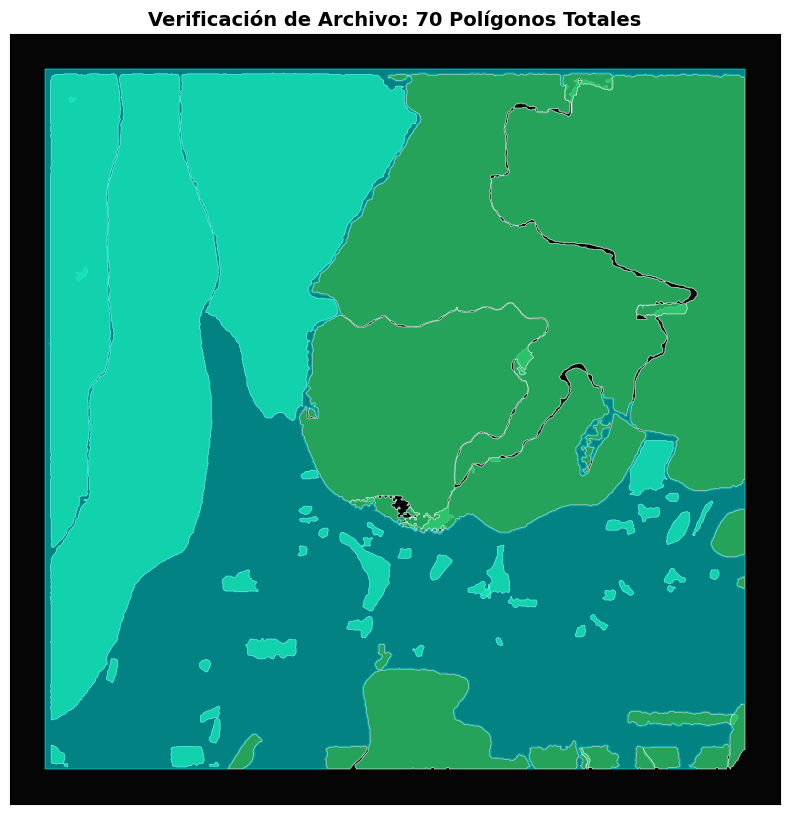

In [41]:
# ==========================================\
# BLOQUE 5.1: VERIFICACIÓN VISUAL (ESTILO CAD MEJORADO)
# ==========================================\
# @title 5.1 Verificar lo que se acaba de guardar
import matplotlib.pyplot as plt
import geopandas as gpd
import os

def verify_last_saved(tile_idx=0):
    fname = f"tile_{tile_idx}.geojson"
    fpath = os.path.join(OUTPUT_DIR, fname)
    
    if not os.path.exists(fpath):
        print(f"❌ No se encontró el archivo {fname}. Dale a 'Guardar' en el bloque 5 primero.")
        return

    print(f"📂 Leyendo: {fname} ...")
    gdf = gpd.read_file(fpath)
    
    if gdf.empty:
        print("⚠️ El archivo existe pero está vacío.")
        return

    print(f"✅ Polígonos en archivo: {len(gdf)}")
    
    try:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        # 1. Fondo Oscuro (Contraste Máximo)
        ax.set_facecolor('#050505') 
        
        # 2. Dibujar Vectores con RELLENO SÓLIDO (Sin transparencias fantasmales)
        if 'source' in gdf.columns:
            # SAM: Verde esmeralda (muy visible sobre negro)
            gdf[gdf['source']=='sam'].plot(ax=ax, facecolor='#2ecc71', alpha=0.8, edgecolor='white', linewidth=0.5, label='SAM', aspect=1)
            
            # Huecos: Cian neón
            gdf[gdf['source']=='gap_fill'].plot(ax=ax, facecolor='#00ffff', alpha=0.5, edgecolor='#00ffff', linewidth=0.8, label='Huecos', aspect=1)
        else:
            gdf.plot(ax=ax, facecolor='white', alpha=0.5, edgecolor='cyan', linewidth=1, aspect=1)
            
        # 3. Ajustes de Coordenadas e Inversión
        ax.invert_yaxis()
        
        # 4. Estética
        ax.set_title(f"Verificación de Archivo: {len(gdf)} Polígonos Totales", fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.show()

    except Exception as e:
        print(f"⚠️ Error visualizando: {e}")
        gdf.plot(aspect=1)
        plt.show()

# Ejecutar verificación del Tile 0 (el primero)
verify_last_saved(tile_idx=0)

# 6

In [49]:
# ==========================================\
# BLOQUE 6: CARGA DE DATOS GUARDADOS (BRIDGE)
# ==========================================\
# @title 6. Cargar Tile Segmentado
import geopandas as gpd
import os

# Variables globales para los siguientes pasos
gdf_tile1 = None
img_tile1 = None

def load_segmentation_data(image_source, output_dir, tile_idx=0):
    """Carga el GeoJSON guardado por el Bloque 5."""
    if image_source is None:
        print("❌ Error: No hay imagen base cargada.")
        return None, None
        
    # 1. Preparar Imagen del Tile
    tile_size = 1024
    full_img = np.array(image_source)
    # Asumimos Tile 0 (Top-Left) para este flujo
    img_tile = full_img[0:tile_size, 0:tile_size] 
    
    # 2. Cargar GeoJSON
    file_name = f"tile_{tile_idx}.geojson"
    file_path = os.path.join(output_dir, file_name)
    
    if os.path.exists(file_path):
        print(f"📂 Cargando archivo: {file_name}")
        try:
            gdf = gpd.read_file(file_path)
            
            # Asegurar que tenga ID
            if 'id' not in gdf.columns:
                gdf['id'] = range(len(gdf))
                
            print(f"✅ Datos listos: {len(gdf)} polígonos cargados en memoria.")
            return gdf, img_tile
        except Exception as e:
            print(f"❌ Error leyendo archivo: {e}")
            return None, img_tile
    else:
        print(f"⚠️ No existe {file_name}. Por favor guarda el tile en el Bloque 5 primero.")
        return None, img_tile

# Ejecución
if 'processed_image_global' in globals():
    gdf_tile1, img_tile1 = load_segmentation_data(processed_image_global, OUTPUT_DIR, tile_idx=0)
else:
    print("⚠️ Falta la imagen global.")

📂 Cargando archivo: tile_0.geojson
✅ Datos listos: 70 polígonos cargados en memoria.


# Bloque 7

In [42]:
# ==========================================\
# BLOQUE 7: CONFIGURACIÓN GEMINI (SOLO API KEY)
# ==========================================\
# @title 7. Configuración de IA (Gemini)
import google.generativeai as genai
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import cv2
import requests
from PIL import Image as PILImage
import io
import json
import matplotlib.pyplot as plt

# Widget simple para la API Key
w_gemini_key = widgets.Password(description="Gemini API Key:", style={'description_width': 'initial'}, layout=widgets.Layout(width='50%'))
btn_auth = widgets.Button(description="🔐 Activar Gemini", button_style='success')
out_auth = widgets.Output()

gemini_configured = False

def autenticar(b):
    global gemini_configured
    with out_auth:
        clear_output()
        if w_gemini_key.value:
            try:
                genai.configure(api_key=w_gemini_key.value)
                # Test rápido de conexión
                m = genai.GenerativeModel('gemini-3-flash-preview')
                _ = m.generate_content("Hola")
                gemini_configured = True
                print("✅ Gemini API conectada y lista.")
            except Exception as e:
                print(f"❌ Error de API Key: {e}")
        else:
            print("⚠️ Por favor ingresa tu API Key.")

btn_auth.on_click(autenticar)
display(widgets.VBox([widgets.HTML("<b>🤖 Configuración del Cerebro (Gemini)</b>"), w_gemini_key, btn_auth, out_auth]))

# Bloque 8

In [43]:
# ==========================================\
# BLOQUE 8: ANÁLISIS DE LEYENDA (GEMINI VISION)
# ==========================================\
# @title 8. Digitalización de la Leyenda Geológica
import pandas as pd
import requests

# URL RAW directa (convertida desde tu blob link)
LEGEND_URL = "https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/leyenda_giron.png"

def analyze_legend(url):
    print(f"📥 Descargando leyenda: {url}...")
    img_data = requests.get(url).content
    
    # Prompt para Gemini Vision
    prompt = """
    Analiza esta leyenda de mapa geológico. 
    Genera una tabla JSON estricta donde cada entrada represente una unidad litológica.
    Campos requeridos:
    1. 'codigo': El código corto (ej. Tms, Ki, etc.) si es visible.
    2. 'nombre_litologia': El nombre completo de la unidad o roca.
    3. 'descripcion_visual': Breve descripción de la trama (ej. lineas rojas, cruces, puntos).
    4. 'color_hex': El código de color HEX aproximado dominante del recuadro.
    
    Salida solo JSON puro, sin markdown.
    """
    
    try:
        model = genai.GenerativeModel('gemini-3-flash-preview') # Usamos Flash para rapidez y visión
        
        # Crear objeto imagen para Gemini
        from PIL import Image as PILImage
        import io
        img_pil = PILImage.open(io.BytesIO(img_data))
        
        print("🧠 Gemini analizando leyenda...")
        response = model.generate_content([prompt, img_pil])
        
        # Limpieza de respuesta (quitar ```json si existe)
        txt = response.text.replace("```json", "").replace("```", "").strip()
        data = json.loads(txt)
        
        df = pd.DataFrame(data)
        return df
        
    except Exception as e:
        print(f"❌ Error analizando leyenda: {e}")
        return pd.DataFrame()

# Ejecución
df_legend = analyze_legend(LEGEND_URL)
if not df_legend.empty:
    print("✅ Leyenda Digitalizada:")
    display(df_legend)
else:
    print("⚠️ No se pudo extraer la leyenda.")

📥 Descargando leyenda: https://raw.githubusercontent.com/DalemberV/Geodigit/main/Digitalizacion_Automatica/Mapas%20geol%C3%B3gicos/leyenda_giron.png...
🧠 Gemini analizando leyenda...
✅ Leyenda Digitalizada:


,codigo,nombre_litologia,descripcion_visual,color_hex
0,QA,Depósito aluvial,Recuadro de color amarillo sólido,#FFFF54
1,QT,Terraza,Recuadro de color amarillo sólido,#FFFF54
2,QC,Depósito coluvial,Recuadro de color amarillo sólido,#FFFF54
3,n5n6Tq,Formación Tarqui,Recuadro de color naranja claro,#FFAD5B
4,n1Qs,Formación Quimsacocha,Recuadro de color salmón/naranja,#FF8A5B
5,n5n6Tt,Formación Turi,Recuadro de color salmón/naranja,#FF8A5B
6,n1Tp,Formación Turupamba,Recuadro de color salmón/naranja,#FF8A5B
7,n5n6Uy,Formación Uchucay,Recuadro de color salmón/naranja,#FF8A5B
8,n1n2SI,Formación Santa Isabel,Recuadro de color beige amarillento,#FCEB92
9,n3n4N,Formación Nabón,Recuadro de color naranja intenso,#FF9D4D


# Bloque 9

In [50]:
# ==========================================\
# BLOQUE 9: EXTRACCIÓN DE COLOR (FIX MULTIPOLYGON)
# ==========================================\
# @title 9. Extracción de Rasgos (Robusta)

def extract_color_features(gdf, source_img):
    if gdf is None or source_img is None: return print("❌ Faltan datos.")
    
    print(f"🎨 Procesando {len(gdf)} polígonos...")
    rgb_results = []
    img_arr = np.array(source_img)
    
    for idx, row in gdf.iterrows():
        poly = row.geometry
        
        # 1. Bounding Box Seguro
        minx, miny, maxx, maxy = map(int, poly.bounds)
        h, w = img_arr.shape[:2]
        minx, miny = max(0, minx), max(0, miny)
        maxx, maxy = min(w, maxx), min(h, maxy)
        
        roi = img_arr[miny:maxy, minx:maxx]
        crop_h, crop_w = roi.shape[:2]
        
        if crop_w == 0 or crop_h == 0:
            rgb_results.append([0,0,0]); continue
            
        # 2. Máscara Local
        mask_crop = np.zeros((crop_h, crop_w), dtype=np.uint8)
        
        # --- FIX: Manejo de MultiPolygon ---
        if poly.geom_type == 'MultiPolygon':
            geoms = list(poly.geoms)
        else:
            geoms = [poly]
            
        for p in geoms:
            # Trasladar coordenadas al crop local
            local_coords = [(x - minx, y - miny) for x, y in p.exterior.coords]
            pts = np.array(local_coords, np.int32)
            cv2.fillPoly(mask_crop, [pts], 255)
            
        # 3. Promedio
        mean_val = cv2.mean(roi, mask=mask_crop)[:3]
        rgb_results.append([int(c) for c in mean_val])

    gdf['avg_rgb'] = rgb_results
    print(f"✅ Extracción terminada. Total procesado: {len(gdf)} registros.")
    return gdf

if gdf_tile1 is not None:
    gdf_processed = extract_color_features(gdf_tile1, img_tile1)
    # Mostramos head pero indicamos el total real
    print(f"Mostrando primeros 5 de {len(gdf_processed)}:")
    display(gdf_processed[['id', 'avg_rgb']].head())


🎨 Procesando 70 polígonos...
✅ Extracción terminada. Total procesado: 70 registros.
Mostrando primeros 5 de 70:


,id,avg_rgb
0,0,"[225, 110, 29]"
1,1,"[115, 110, 79]"
2,2,"[142, 119, 77]"
3,3,"[55, 220, 22]"
4,4,"[247, 206, 128]"


# Bloque 10

🧠 Clasificando 70 polígonos con IA...
🔍 La IA devolvió 70 clasificaciones.
✅ Clasificación lista.


,id,avg_rgb,litologia
0,0,"[225, 110, 29]",Formación Nabón
1,1,"[115, 110, 79]",Andesita
2,2,"[142, 119, 77]",Formación Sacapalca
3,3,"[55, 220, 22]",Unidad Pallatanga
4,4,"[247, 206, 128]",Formación Plancharumi


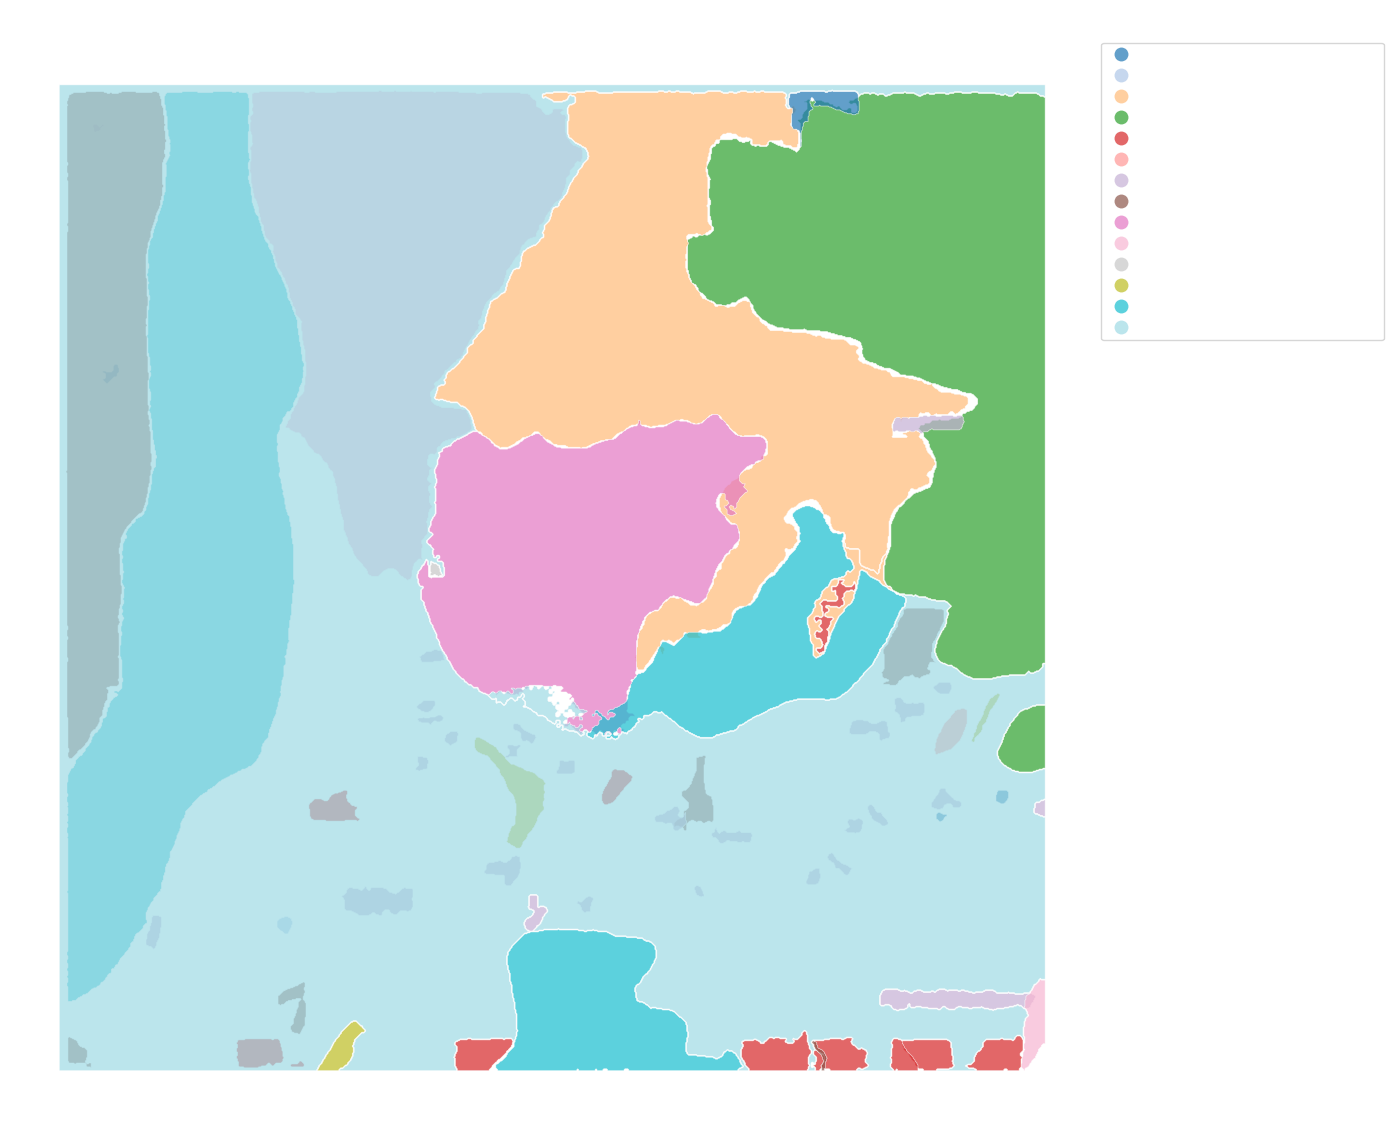

In [52]:
# ==========================================\
# BLOQUE 10: MATCHING IA (POR NOMBRES)
# ==========================================\
# @title 10. Clasificación Geológica por Nombre
def ai_matching(gdf, legend_df):
    if not gemini_configured: return
    print(f"🧠 Clasificando {len(gdf)} polígonos con IA...")
    
    # Preparamos datos ligeros
    poly_data = gdf[['id', 'avg_rgb']].to_csv(index=False)
    
    # Usamos las columnas solicitadas
    cols_legend = []
    for c in ['codigo', 'nombre_litologia', 'descripcion_visual', 'color_hex']:
        if c in legend_df.columns: cols_legend.append(c)
    
    legend_data = legend_df[cols_legend].to_csv(index=False)
    
    prompt = f"""
    Actúa como un geólogo experto. Tu tarea es asignar el 'nombre_litologia' de la leyenda a cada polígono.
    
    CRITERIOS DE EMPATE:
    1. Compara el 'avg_rgb' del polígono con el 'color_hex' de la leyenda.
    2. Si tienes dudas, usa la 'descripcion_visual' para desempate.
    3. Asigna siempre el NOMBRE COMPLETO ('nombre_litologia'), no solo el código.
    
    LEYENDA DISPONIBLE:
    {legend_data}
    
    POLÍGONOS A CLASIFICAR:
    {poly_data}
    
    FORMATO DE RESPUESTA (JSON PURO):
    Devuelve una lista completa para TODOS los IDs. No omitas ninguno.
    [
      {{ "id": 0, "litologia": "Nombre Litologia A" }},
      {{ "id": 1, "litologia": "Nombre Litologia B" }}
    ]
    """
    
    try:
        model = genai.GenerativeModel('gemini-3-flash-preview')
        resp = model.generate_content(prompt)
        text_clean = resp.text.replace("```json","").replace("```","").strip()
        matches = json.loads(text_clean)
        
        df_matches = pd.DataFrame(matches)
        
        # Validación de cruce
        print(f"🔍 La IA devolvió {len(df_matches)} clasificaciones.")
        
        # Merge seguro (Left Join asegura que no se pierdan polígonos aunque la IA falle)
        result = gdf.merge(df_matches, on='id', how='left')
        
        # Rellenar nulos para evitar huecos en el mapa
        if 'litologia' in result.columns:
            result['litologia'] = result['litologia'].fillna("Sin Clasificar")
            
        return result
        
    except Exception as e:
        print(f"❌ Error IA: {e}")
        return gdf

if 'gdf_processed' in globals() and not df_legend.empty:
    gdf_final = ai_matching(gdf_processed, df_legend)
    print("✅ Clasificación lista.")
    
    cols_to_show = ['id', 'avg_rgb']
    if 'litologia' in gdf_final.columns: cols_to_show.append('litologia')
        
    display(gdf_final[cols_to_show].head())




In [56]:
# ==========================================\
# BLOQUE 11: VISUALIZACIÓN INTERACTIVA (FOLIUM)
# ==========================================\
# @title 11. Resultado Final Interactivo (Hover + Click)
import folium
from folium import plugins
import json

def interactive_map_result(gdf):
    if gdf is None or gdf.empty:
        print("❌ No hay datos para visualizar.")
        return

    # 1. Preparar Datos
    # Folium necesita lat/lon reales para mapas base, pero aquí usaremos un sistema de coordenadas de imagen (Simple CRS)
    # Sin embargo, para simplificar y que funcione rápido en Colab, convertiremos la geometría a GeoJSON puro y lo pintaremos sobre un fondo negro.
    
    gdf_viz = gdf.copy()
    
    # --- FIX AFFINE TRANSFORM ---
    # Invertir Y para que coincida con la imagen (0,0 arriba-izquierda -> latitud positiva)
    # En mapas: Y crece hacia arriba (Norte). En imágenes: Y crece hacia abajo.
    # Transformación: x' = x * f, y' = -y * f
    f = 0.0001
    
    # Aplicamos la transformación a TODA la columna a la vez (Vectorizado)
    gdf_viz['geometry'] = gdf_viz['geometry'].affine_transform([f, 0, 0, -f, 0, 0])
    
    # --- FIX SUPERPOSICIÓN (LAYERING) ---
    # Problema: Polígonos grandes tapan a los pequeños al hacer hover.
    # Solución: Ordenar por área descendente. 
    # Folium dibuja en orden: el primero de la lista queda ABAJO, el último queda ARRIBA.
    # Al poner los grandes primero (descendente), quedan al fondo y los pequeños quedan accesibles al mouse.
    gdf_viz['area_calc'] = gdf_viz.geometry.area
    gdf_viz = gdf_viz.sort_values('area_calc', ascending=False)
    
    # Calcular centro
    bounds = gdf_viz.total_bounds
    center_y = (bounds[1] + bounds[3]) / 2
    center_x = (bounds[0] + bounds[2]) / 2
    
    # 2. Crear Mapa (Fondo oscuro)
    m = folium.Map(
        location=[center_y, center_x], 
        zoom_start=15, 
        tiles='CartoDB dark_matter', # Fondo oscuro estilo CAD
        control_scale=True
    )
    
    # 3. Estilos Dinámicos
    # Asignar colores únicos a cada litología
    unique_litos = gdf_viz['litologia'].unique() if 'litologia' in gdf_viz.columns else []
    import matplotlib.colors as mcolors
    # Generar paleta
    colors = list(mcolors.TABLEAU_COLORS.values()) * 5
    lito_color_map = {lito: colors[i % len(colors)] for i, lito in enumerate(unique_litos)}
    
    def style_function(feature):
        lito = feature['properties'].get('litologia', 'Sin Clasificar')
        return {
            'fillColor': lito_color_map.get(lito, '#00ffff'), # Cian por defecto
            'color': 'white', # Borde blanco
            'weight': 0.5,
            'fillOpacity': 0.6
        }

    def highlight_function(feature):
        return {
            'fillColor': 'yellow',
            'color': 'yellow',
            'weight': 2,
            'fillOpacity': 0.9
        }

    # 4. Tooltip (Hover) y Popup (Click)
    tooltip_fields = ['id', 'litologia'] if 'litologia' in gdf_viz.columns else ['id']
    popup_fields = ['id', 'litologia', 'avg_rgb'] if 'litologia' in gdf_viz.columns else ['id', 'avg_rgb']
    
    # 5. Añadir Capa GeoJSON
    folium.GeoJson(
        gdf_viz,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=folium.GeoJsonTooltip(
            fields=tooltip_fields,
            aliases=['ID:', 'Unidad:'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
        ),
        popup=folium.GeoJsonPopup(fields=popup_fields)
    ).add_to(m)
    
    # Título flotante
    title_html = '''
     <div style="position: fixed; 
     top: 10px; left: 50px; width: 300px; height: 30px; 
     z-index:9999; font-size:16px; font-weight: bold; color: white;">
     🗺️ Mapa Geológico Interactivo
     </div>
     '''
    m.get_root().html.add_child(folium.Element(title_html))

    display(m)

if 'gdf_final' in globals():
    interactive_map_result(gdf_final)